<a href="https://colab.research.google.com/github/inf032/introducaoML/blob/master/ENEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.impute._base import _BaseImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


import warnings

In [3]:
class ImputerWithMissingMark (BaseEstimator, TransformerMixin):

    def transformColunas_IMPUTED(self, X) -> pd.DataFrame :
      copia = X.copy()
      for col in self.col_name_with_nan :
          copia[f'{col}{self.postfix}'] = copia[col].isna().astype(int)
      return copia      

    def col_with_nan(self, X) -> list:
      list_col_with_nan = []
      copia = X.copy()
      for col in copia.columns :
        if(copia[col].isna().sum() > 0) :
          list_col_with_nan.append(col)
      return list_col_with_nan

    def col_num_with_nan(self, X) -> list:
      cols = X.shape[1]
      list_col_with_nan = []
      for col in range(cols):    
          if(np.count_nonzero(np.isnan(X[:,col])) > 0) :  
              list_col_with_nan.append(col)
      return list_col_with_nan        

    def __init__(self, imputer=KNNImputer(), postfix = '_IMPUTED'):
      self.imputer = imputer
      self.col_name = None
      self.fitted = False
      self.col_name_with_nan = None
      self.col_number_with_nan = None
      self.postfix = postfix

    def fit_DF(self, X):
      self.col_name = X.columns.values
      self.col_name_with_nan = self.col_with_nan(X)

    def fit_NP(self, X):
      self.col_number_with_nan = self.col_num_with_nan(X)

    def transform_DF(self, X):
      copia = self.transformColunas_IMPUTED(X)
      transformed = pd.DataFrame(self.imputer.transform(copia[self.col_name]))
      transformed.columns = X.columns
      transformed.index = X.index
      for col in self.col_name_with_nan :
        transformed[f'{col}{self.postfix}'] = copia[f'{col}{self.postfix}']
      return transformed

    def transform_NP(self, X):
      transformed = np.copy(X)
      vazio = np.zeros(shape=(X.shape[0], len(self.col_number_with_nan)))
      for col in self.col_number_with_nan:
        a_nan = [1 if np.isnan(x) else 0 for x in transformed[:,col]]
        vazio = np.append(vazio, np.c_[a_nan], axis = 1)
      transformed = self.imputer.transform(transformed)  
      for col in range(vazio.shape[1]) :
        transformed = np.append(transformed, np.c_[vazio[:, col]], axis = 1)
      return transformed      

    def fit(self, X, y=None):
      if(self.fitted == False) :
        self.fitted = True
        if(type(X) == pd.DataFrame) :
          self.fit_DF(X)
        else :
          self.fit_NP(X)  
        self.imputer.fit(X)
      return self

    def transform(self, X, y=None):
      if(self.fitted == True) :
        if(self.col_name is not None) :
          transformed = self.transform_DF(X)    
        else :
          transformed = self.transform_NP(X)    
        return transformed
      else :
        return X

    def get_params(self, deep=True):
      # retorna um dicionário com os atributos e seus respectivos valores
      return {"imputer": self.imputer, 
              "postfix": self.postfix}
      
    def set_params(self, **parameters):
      # iterando pelos elementos passados e definindo-os na classe
      for parameter, value in parameters.items():
        setattr(self, parameter, value)
      return self 

In [4]:
def parse_codigo(codigo) :
  if codigo is None :
    return np.NaN, np.NaN, np.NaN
  regiao = codigo // 1000000
  uf = codigo // 100000
  municipio = (codigo % 100000) // 10
  return regiao, uf, municipio

**Excluindo dados futuros** 

In [5]:
SEED = 48
np.random.seed(SEED)
warnings.filterwarnings(action='once')

dados = pd.read_csv('https://raw.githubusercontent.com/inf032/introducaoML/master/data/microdados_sample.csv')
#https://raw.githubusercontent.com/inf032/introducaoML/master/data/sample_14.csv
dados['NU_NOTA'] = dados.NU_NOTA_CN + dados.NU_NOTA_CH + dados.NU_NOTA_LC +  dados.NU_NOTA_MT + dados.NU_NOTA_REDACAO

dados.drop(columns=['CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT',
                    'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
                    'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH',
                    'TX_GABARITO_LC', 'TX_GABARITO_MT',
                    'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
                    'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_CN', 'NU_NOTA_CH',
                    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
                    'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_STATUS_REDACAO'], inplace=True)

dados.dropna(axis='index', subset=['NU_NOTA'], inplace=True)

In [6]:
preditoras = ['NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
              'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
              'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE',
              'CO_MUNICIPIO_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO', 'CO_UF_NASCIMENTO',
              'SG_UF_NASCIMENTO', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
              'TP_ENSINO', 'IN_TREINEIRO', 'CO_ESCOLA', 'CO_MUNICIPIO_ESC',
              'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC', 'TP_DEPENDENCIA_ADM_ESC',
              'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA',
              'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA',
              'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO',
              'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR',
              'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO',
              'IN_ESTUDA_CLASSE_HOSPITALAR', 'IN_SEM_RECURSO', 'IN_BRAILLE',
              'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO',
              'IN_LIBRAS', 'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL',
              'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
              'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
              'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO',
              'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR',
              'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO',
              'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL',
              'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO',
              'IN_MATERIAL_ESPECIFICO', 'IN_NOME_SOCIAL', 'CO_MUNICIPIO_PROVA',
              'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA', 'SG_UF_PROVA', 'TP_LINGUA',
              'Q001', 'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008',
              'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016',
              'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024',
              'Q025']

alvo = 'NU_NOTA'              

In [7]:
X = dados[preditoras]
y = dados[alvo]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

print(f'Holdout: {X_train.shape[0]} individuos em treino. {X_test.shape[0]} individuos em teste.')



Holdout: 74031 individuos em treino. 18508 individuos em teste.


In [8]:
def processa_preditoras(preditoras) :
    dados = preditoras.copy()
    dados.drop(columns=['NU_INSCRICAO', 'NU_ANO'], inplace=True)
    dados.drop(columns=['CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC'] , inplace=True)
    dados.drop(columns=['CO_ESCOLA', 'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'TP_ENSINO'], inplace=True)
    dados['REGIAO_RESIDENCIA'], dados['UF_RESIDENCIA'], _ = parse_codigo(dados.CO_MUNICIPIO_RESIDENCIA)
    dados['REGIAO_NASCIMENTO'], dados['UF_NASCIMENTO'], _ = parse_codigo(dados.CO_MUNICIPIO_NASCIMENTO)
    dados['REGIAO_PROVA'], dados['UF_PROVA'], _ = parse_codigo(dados.CO_MUNICIPIO_PROVA)
    dados.drop(columns=['CO_MUNICIPIO_RESIDENCIA', 'NO_MUNICIPIO_RESIDENCIA', 
                        'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 
                        'CO_MUNICIPIO_NASCIMENTO', 'NO_MUNICIPIO_NASCIMENTO', 
                        'CO_UF_NASCIMENTO', 'SG_UF_NASCIMENTO',  
                        'CO_MUNICIPIO_PROVA', 'NO_MUNICIPIO_PROVA', 'CO_UF_PROVA',
                        'SG_UF_PROVA'], inplace=True)
    dados['TP_ANO_CONCLUIU'].map({'0':np.nan}, na_action=None)    
    dados['Q001'].replace('H', np.nan, inplace = True)
    dados['Q002'].replace('H', np.nan, inplace = True)
    return dados

**Excluindo dados com baixissima/altissima variância**

In [9]:
X_train_processada = processa_preditoras(X_train)

In [10]:
X_train_processada[X_train_processada.columns[X_train_processada.isna().sum() > 0]].isna().sum() / X_train_processada.shape[0] * 100

Q001                 8.277613
Q002                 2.684011
REGIAO_NASCIMENTO    2.913644
UF_NASCIMENTO        2.913644
dtype: float64

In [11]:
X_train_processada.Q002.value_counts()

E    24627
B    11041
D     9502
C     9388
F     8310
G     6748
A     2428
Name: Q002, dtype: int64

In [12]:
X_train_processada.columns.values

array(['NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
       'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'IN_TREINEIRO', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA',
       'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA',
       'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
       'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE',
       'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR',
       'IN_SEM_RECURSO', 'IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18',
       'IN_LEDOR', 'IN_ACESSO', 'IN_TRANSCRICAO', 'IN_LIBRAS',
       'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL', 'IN_MESA_CADEIRA_RODAS',
       'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA', 'IN_GUIA_INTERPRETE',
       'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL', 'IN_CADEIRA_CANHOTO',
       'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO', 'IN_MOBILIARIO_OBESO',
       'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AUR

In [18]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

onehot_MF_transformer = Pipeline(steps=[('one_hot_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])
onehot_num04_transformer = Pipeline(steps=[('one_hot_num04_encoder', OneHotEncoder(drop='if_binary', sparse=False))])
onehot_num05_transformer = Pipeline(steps=[('one_hot_num05_encoder', OneHotEncoder(drop='if_binary', sparse=False))])
onehot_num14_transformer = Pipeline(steps=[('one_hot_num14_encoder', OneHotEncoder(drop='if_binary', sparse=False))])

onehot_charAF_transformer = Pipeline(steps=[('onehot_charAF_transformer', OneHotEncoder(drop='if_binary', sparse=False))])
oe_charAG_transfomer =  Pipeline(steps=[('oe_charAG_enconder', OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G']], 
                                         handle_unknown= 'use_encoded_value', unknown_value=np.nan))])

oe_charAQ_transfomer =  Pipeline(steps=[('oe_charAQ_enconder', OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q']], 
                                         handle_unknown= 'use_encoded_value', unknown_value=np.nan))])

oe_charAD_transfomer =  Pipeline(steps=[('oe_charAD_enconder', OrdinalEncoder(categories=[['A', 'B', 'C', 'D']], 
                                         handle_unknown= 'use_encoded_value', unknown_value=np.nan))])

oe_charAE_transfomer =  Pipeline(steps=[('oe_charAE_enconder', OrdinalEncoder(categories=[['A', 'B', 'C', 'D', 'E']], 
                                         handle_unknown= 'use_encoded_value', unknown_value=np.nan))])

onehot_AB_transformer = Pipeline(steps=[('one_hot_AB_encoder',  OneHotEncoder(drop='if_binary', sparse=False))])

oe_REGION_transfomer =  Pipeline(steps=[('oe_region_enconder', OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value=np.nan))])
oe_UF_transfomer =  Pipeline(steps=[('oe_uf_enconder', OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value=np.nan))])


col_transformer = ColumnTransformer(transformers=[('sexo', onehot_MF_transformer, ['TP_SEXO']),
                                                  ('num04', onehot_num04_transformer, ['TP_ESTADO_CIVIL', 'TP_NACIONALIDADE']),
                                                  ('num05', onehot_num05_transformer, ['TP_COR_RACA']),
                                                  ('num14', onehot_num14_transformer, ['TP_ST_CONCLUSAO', 'TP_ESCOLA']),
                                                  ('charAG1', oe_charAG_transfomer, ['Q001']),
                                                  ('charAG2', oe_charAG_transfomer, ['Q002']),
                                                  ('charAQ6', oe_charAQ_transfomer, ['Q006']),
                                                  ('charAD7', oe_charAD_transfomer, ['Q007']),
                                                  ('charAF3_4', onehot_charAF_transformer, ['Q003', 'Q004']),
                                                  ('charAE8', oe_charAE_transfomer, ['Q008']),
                                                  ('charAE9', oe_charAE_transfomer, ['Q009']),
                                                  ('charAE10', oe_charAE_transfomer, ['Q010']),
                                                  ('charAE11', oe_charAE_transfomer, ['Q011']),
                                                  ('charAE12', oe_charAE_transfomer, ['Q012']),
                                                  ('charAE13', oe_charAE_transfomer, ['Q013']),
                                                  ('charAE14', oe_charAE_transfomer, ['Q014']),
                                                  ('charAE15', oe_charAE_transfomer, ['Q015']),
                                                  ('charAE16', oe_charAE_transfomer, ['Q016']),
                                                  ('charAE17', oe_charAE_transfomer, ['Q017']),
                                                  ('charAE19', oe_charAE_transfomer, ['Q019']),
                                                  ('charAE22', oe_charAE_transfomer, ['Q022']),
                                                  ('charAE24', oe_charAE_transfomer, ['Q024']),
                                                  ('charAB18', onehot_AB_transformer, ['Q018']),
                                                  ('charAB20', onehot_AB_transformer, ['Q020']),
                                                  ('charAB21', onehot_AB_transformer, ['Q021']),
                                                  ('charAB23', onehot_AB_transformer, ['Q023']),
                                                  ('charAB25', onehot_AB_transformer, ['Q025']),
                                                  ('region_residencia', oe_REGION_transfomer, ['REGIAO_RESIDENCIA']),
                                                  ('region_nascimento', oe_REGION_transfomer, ['REGIAO_NASCIMENTO']),
                                                  ('region_prova', oe_REGION_transfomer, ['REGIAO_PROVA']),
                                                  ('uf_residencia', oe_REGION_transfomer, ['UF_RESIDENCIA']),
                                                  ('uf_nascimento', oe_REGION_transfomer, ['UF_NASCIMENTO']),
                                                  ('uf_prova', oe_REGION_transfomer, ['UF_PROVA'])
                                                  ],
                                    remainder='passthrough')

modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()),
                         ('imputer', ImputerWithMissingMark(imputer=SimpleImputer())),
                         ('estimador',  XGBRegressor(objective='reg:squarederror'))
                         ]).fit(X_train_processada, y_train)


X_test_processada = processa_preditoras(X_test)


print(np.sqrt(mean_squared_error(y_test, modelo.predict(X_test_processada))))
print(modelo.score(X_test_processada, y_test))


328.7916601849763
0.3762932074156611


In [18]:
#modelo.score(X_test_processada, y_test)

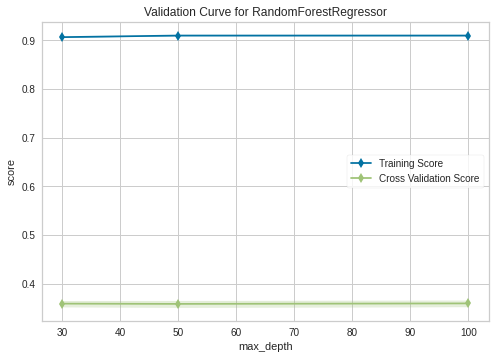

In [19]:
from yellowbrick.model_selection import ValidationCurve

vc = ValidationCurve(RandomForestRegressor(), param_name='max_depth', 
                     param_range=[30, 50, 100], cv=5)

modelo = Pipeline(steps=[('step_one', col_transformer), ('ss',  StandardScaler()),
                         ('imputer', ImputerWithMissingMark(imputer=SimpleImputer())),
                         ('vc',  vc)]).fit(X_train_processada, y_train)

vc.show()